In [1]:
!apt-get install openjdk-21-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-21-openjdk-amd64"
os.environ["SPARK_HOME"] = "/kaggle/working/spark-3.5.5-bin-hadoop3"

In [2]:
!pip install wget
import wget
import os

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=cf0a84f569d49f54907f91614ffee47d5a6723416c1a22f4fc27bf0a28d07237
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score ,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp,unix_timestamp, col,monotonically_increasing_id
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


In [4]:
file_url = 'https://drive.google.com/uc?id=1sOkiSL5_lQcJFscw7EZhRbDU2zWtrmbt&export=download'

# Đọc tệp CSV, using encoding='latin-1'
df = pd.read_csv(file_url, encoding='latin-1')

In [5]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [7]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [8]:
df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [9]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])


In [10]:
df['ORDERDATE'].dtype


dtype('<M8[ns]')

In [11]:
df.describe()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2004-05-11 00:16:49.989373056,2.717676,7.092455,2003.81509,100.715551
min,10100.000000,6.000000,26.880000,1.000000,482.130000,2003-01-06 00:00:00,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2003-11-06 12:00:00,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,2004-06-15 00:00:00,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,2004-11-17 12:00:00,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,2005-05-31 00:00:00,4.000000,12.000000,2005.00000,214.000000
std,92.085478,9.741443,20.174277,4.225841,1841.865106,NaN,1.203878,3.656633,0.69967,40.187912


In [12]:
df.isnull().sum()


ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [13]:
df_cleaned = df.dropna(subset=['STATE', 'POSTALCODE', 'TERRITORY','ADDRESSLINE2'])


In [14]:
df_cleaned.isnull().sum()


ORDERNUMBER         0
QUANTITYORDERED     0
PRICEEACH           0
ORDERLINENUMBER     0
SALES               0
ORDERDATE           0
STATUS              0
QTR_ID              0
MONTH_ID            0
YEAR_ID             0
PRODUCTLINE         0
MSRP                0
PRODUCTCODE         0
CUSTOMERNAME        0
PHONE               0
ADDRESSLINE1        0
ADDRESSLINE2        0
CITY                0
STATE               0
POSTALCODE          0
COUNTRY             0
TERRITORY           0
CONTACTLASTNAME     0
CONTACTFIRSTNAME    0
DEALSIZE            0
dtype: int64

In [15]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [16]:
print(df.describe())


        ORDERNUMBER  QUANTITYORDERED    PRICEEACH  ORDERLINENUMBER  \
count   2823.000000      2823.000000  2823.000000      2823.000000   
mean   10258.725115        35.092809    83.658544         6.466171   
min    10100.000000         6.000000    26.880000         1.000000   
25%    10180.000000        27.000000    68.860000         3.000000   
50%    10262.000000        35.000000    95.700000         6.000000   
75%    10333.500000        43.000000   100.000000         9.000000   
max    10425.000000        97.000000   100.000000        18.000000   
std       92.085478         9.741443    20.174277         4.225841   

              SALES                      ORDERDATE       QTR_ID     MONTH_ID  \
count   2823.000000                           2823  2823.000000  2823.000000   
mean    3553.889072  2004-05-11 00:16:49.989373056     2.717676     7.092455   
min      482.130000            2003-01-06 00:00:00     1.000000     1.000000   
25%     2203.430000            2003-11-06 12:00:0

#VISUALIZATION

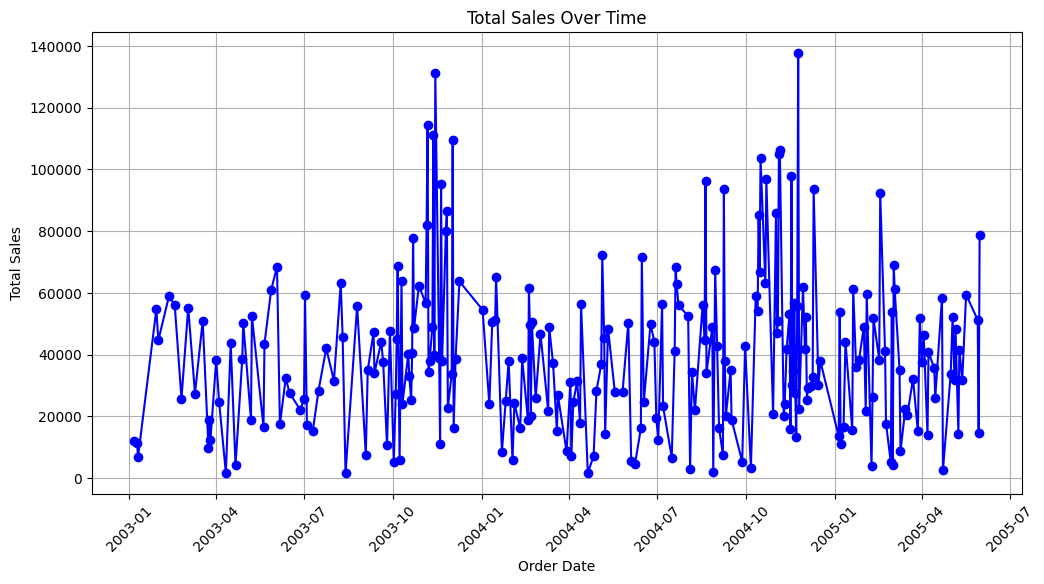

In [17]:
# Chuyển đổi cột 'ORDERDATE' thành kiểu datetime nếu chưa thực hiện
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Tổng doanh thu theo ngày
df_daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()

# Vẽ biểu đồ tổng doanh thu theo thời gian
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales['ORDERDATE'], df_daily_sales['SALES'], marker='o', linestyle='-', color='b')
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


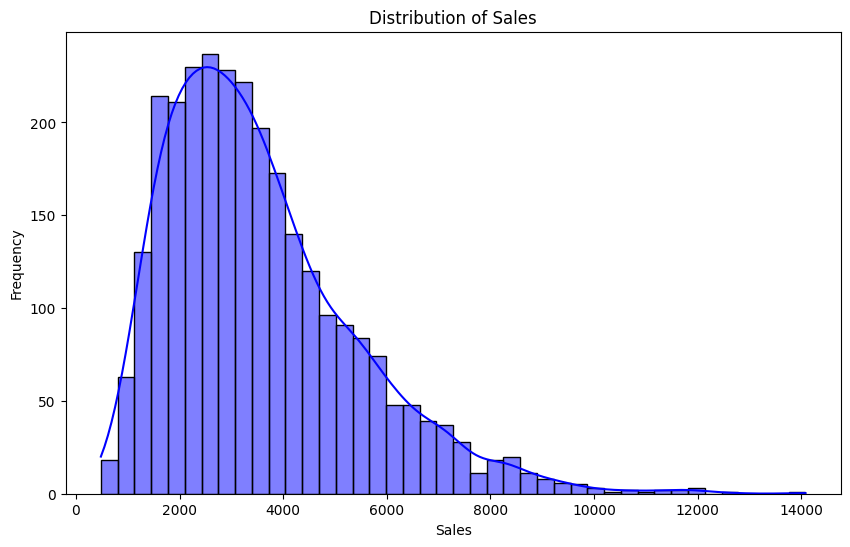

In [18]:
# Sales Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['SALES'], kde=True, color='blue')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

#SALES:

Trung bình doanh thu là 3553.89, với mức độ biến động lớn (độ lệch chuẩn 1841.87). Giá trị doanh thu thấp nhất là 482.13 và cao nhất là 14082.8.
Điều này cho thấy sự phân bổ doanh thu khá rộng, có thể có một số đơn hàng có doanh thu cao vượt trội so với phần còn lại.







PRICEEACH:

Giá trung bình mỗi sản phẩm là 83.66, dao động từ 26.88 đến 100.

Mức giá có sự phân bổ tương đối đều, không có giá sản phẩm vượt quá 100.

MSRP:

Giá bán lẻ đề xuất trung bình là 100.72, dao động từ 33 đến 214. Điều này cho thấy có một sự chênh lệch giữa giá thực tế và giá bán lẻ đề xuất.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


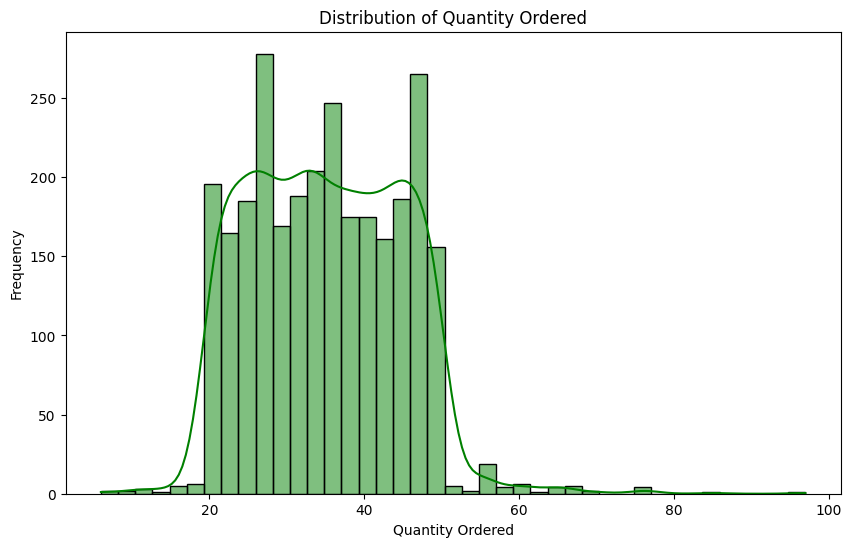

In [19]:
# Quantity Ordered Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['QUANTITYORDERED'], kde=True, color='green')
plt.title('Distribution of Quantity Ordered')
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.show()


#QUANTITYORDERED:

Trung bình số lượng đơn hàng là 35.09, với số lượng thấp nhất là 6 và cao nhất là 97.

Phân phối số lượng đơn hàng có thể cho thấy một số sản phẩm hoặc đơn hàng có số lượng lớn trong khi phần lớn các đơn hàng có số lượng thấp hơn.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


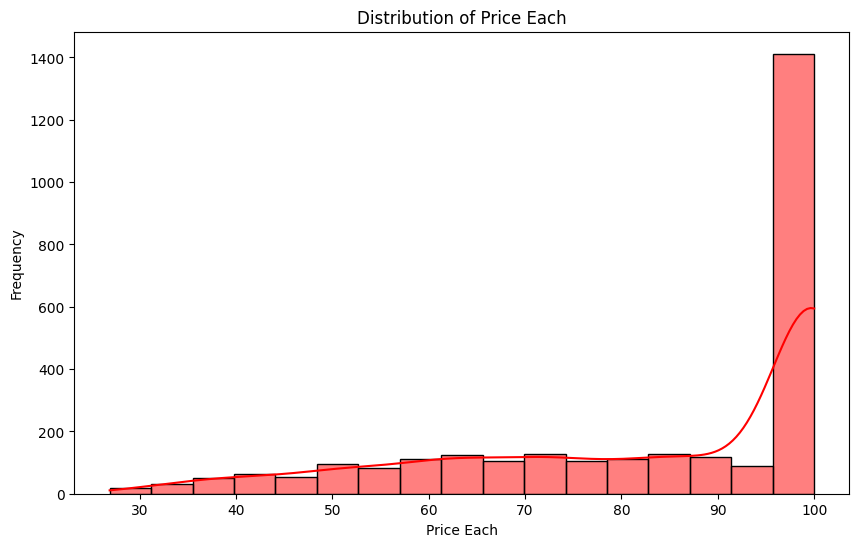

In [20]:
# Price Each Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['PRICEEACH'], kde=True, color='red')
plt.title('Distribution of Price Each')
plt.xlabel('Price Each')
plt.ylabel('Frequency')
plt.show()

#PRICEEACH:

Giá trung bình mỗi sản phẩm là 83.66, dao động từ 26.88 đến 100.

Mức giá có sự phân bổ tương đối đều, không có giá sản phẩm vượt quá 100.

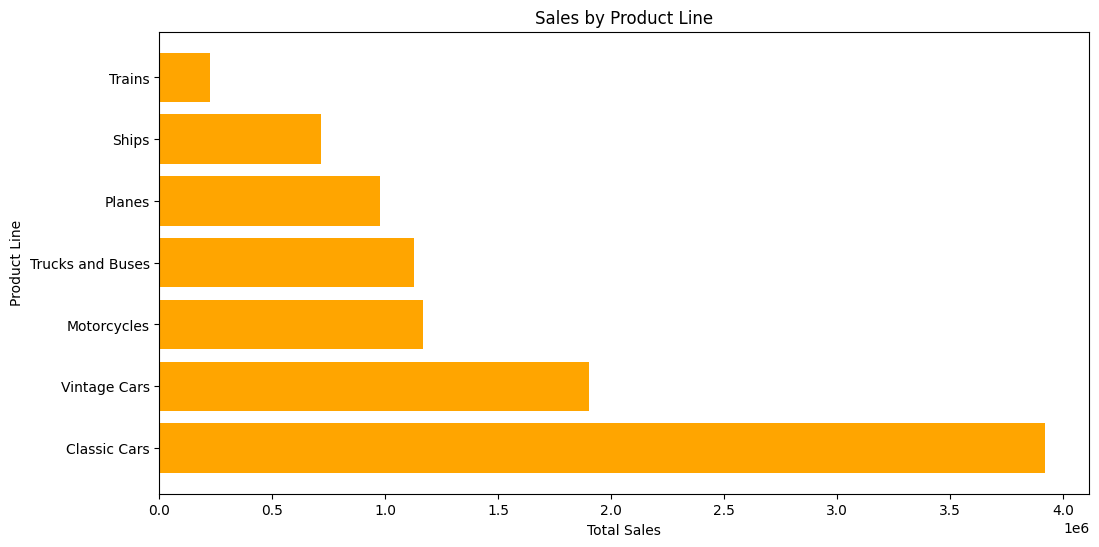

In [21]:
# Tổng doanh thu theo sản phẩm
df_product_sales = df.groupby('PRODUCTLINE')['SALES'].sum().reset_index()

# Sắp xếp sản phẩm theo doanh thu giảm dần
df_product_sales = df_product_sales.sort_values(by='SALES', ascending=False)

# Vẽ biểu đồ doanh thu theo sản phẩm
plt.figure(figsize=(12,6))
plt.barh(df_product_sales['PRODUCTLINE'], df_product_sales['SALES'], color='orange')
plt.title('Sales by Product Line')
plt.xlabel('Total Sales')
plt.ylabel('Product Line')
plt.show()


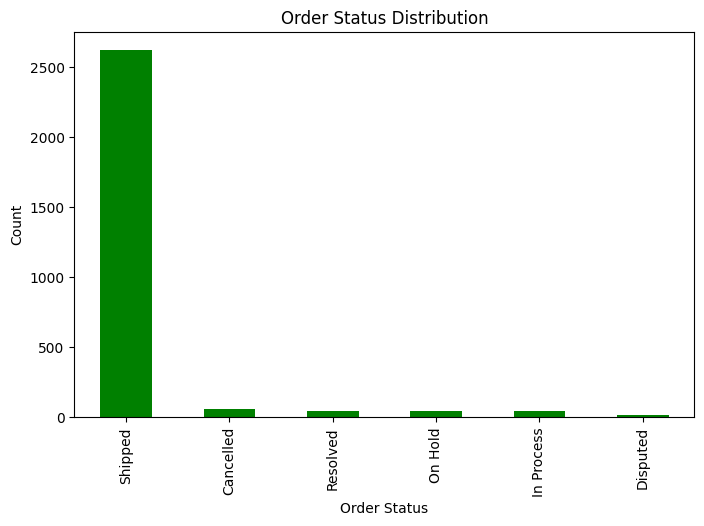

In [22]:
# Số lượng đơn hàng theo trạng thái
df_order_status = df['STATUS'].value_counts()

# Vẽ biểu đồ phân phối trạng thái đơn hàng
plt.figure(figsize=(8,5))
df_order_status.plot(kind='bar', color='green')
plt.title('Order Status Distribution')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.show()


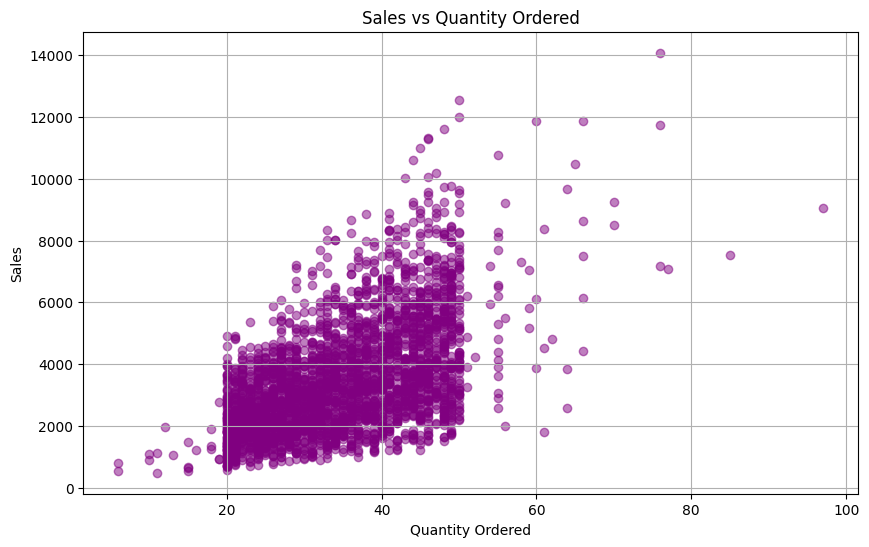

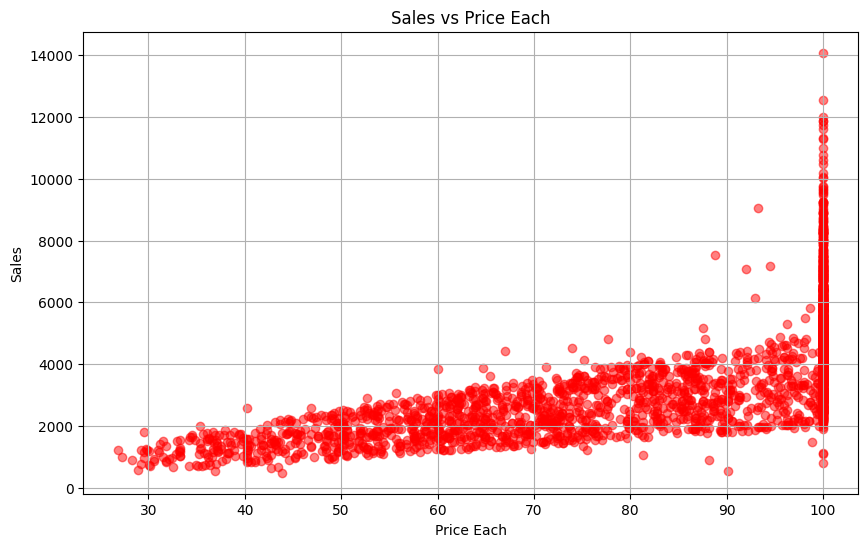

In [23]:
# Trực quan hóa mối quan hệ giữa doanh thu và số lượng đơn hàng
plt.figure(figsize=(10,6))
plt.scatter(df['QUANTITYORDERED'], df['SALES'], alpha=0.5, color='purple')
plt.title('Sales vs Quantity Ordered')
plt.xlabel('Quantity Ordered')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Trực quan hóa mối quan hệ giữa giá mỗi sản phẩm và doanh thu
plt.figure(figsize=(10,6))
plt.scatter(df['PRICEEACH'], df['SALES'], alpha=0.5, color='red')
plt.title('Sales vs Price Each')
plt.xlabel('Price Each')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


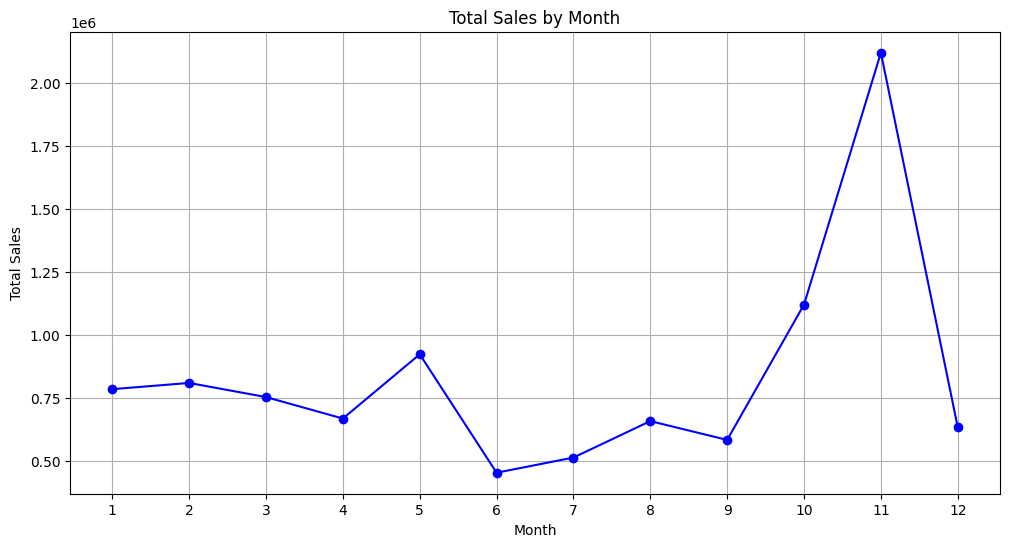

In [24]:
# Thêm cột 'Month' vào DataFrame
df['Month'] = df['ORDERDATE'].dt.month

# Tính tổng doanh thu theo tháng
df_monthly_sales = df.groupby('Month')['SALES'].sum().reset_index()

# Vẽ biểu đồ tổng doanh thu theo tháng
plt.figure(figsize=(12,6))
plt.plot(df_monthly_sales['Month'], df_monthly_sales['SALES'], marker='o', linestyle='-', color='blue')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


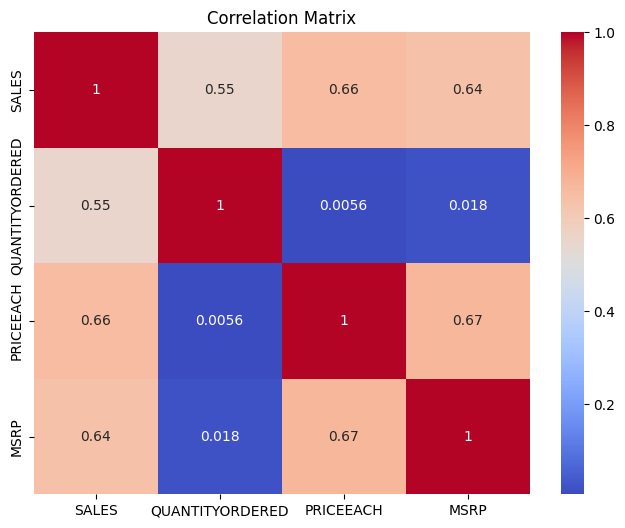

In [25]:
# Chọn các cột số để tính toán mối tương quan
correlation_matrix = df[['SALES', 'QUANTITYORDERED', 'PRICEEACH', 'MSRP']].corr()

# Vẽ biểu đồ heatmap của ma trận tương quan
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


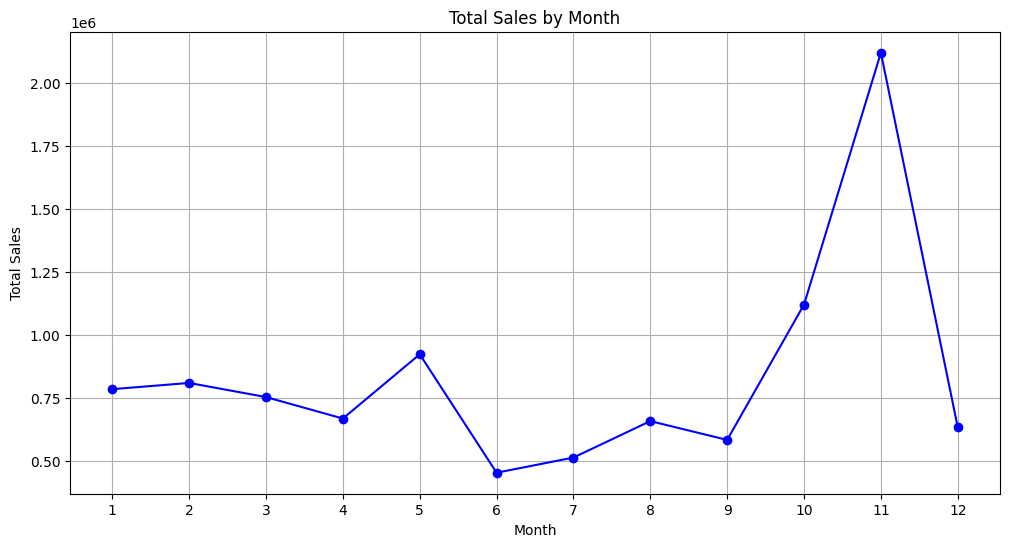

In [26]:
# Tổng doanh thu theo tháng
df['Month'] = df['ORDERDATE'].dt.month
df_monthly_sales = df.groupby('Month')['SALES'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(df_monthly_sales['Month'], df_monthly_sales['SALES'], marker='o', linestyle='-', color='blue')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


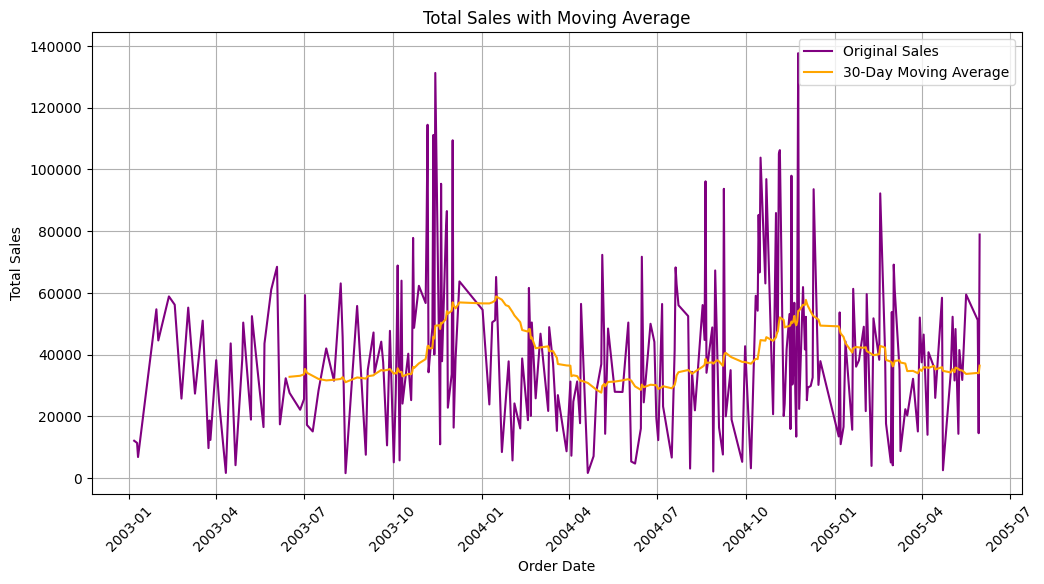

In [27]:
# Assuming df_daily_sales is your main dataset
df_daily_sales['MA_30'] = df_daily_sales['SALES'].rolling(window=30).mean()

# Plotting
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales['ORDERDATE'], df_daily_sales['SALES'], color='purple', label='Original Sales')
plt.plot(df_daily_sales['ORDERDATE'], df_daily_sales['MA_30'], color='orange', label='30-Day Moving Average')
plt.title('Total Sales with Moving Average')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#ADF

In [28]:
from statsmodels.tsa.stattools import adfuller

# Test ADF trên doanh thu
adf_test = adfuller(df['SALES'])
adf_test_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}

adf_test_result


{'ADF Statistic': -6.826767865419293,
 'p-value': 1.9389359998346746e-09,
 'Critical Values': {'1%': -3.4326884449020496,
  '5%': -2.862573161055339,
  '10%': -2.567319983412899}}

p-value (1.94e-09): Vì p-value nhỏ hơn 0.05, ta có thể kết luận rằng chuỗi thời gian là dừng (stationary).

ADF Statistic (-6.83): Giá trị thống kê ADF là -6.83, lớn hơn các giá trị quan trọng ở mức 1% (-3.43), 5% (-2.86), và 10% (-2.57), điều này cũng cho thấy chuỗi thời gian là dừng.



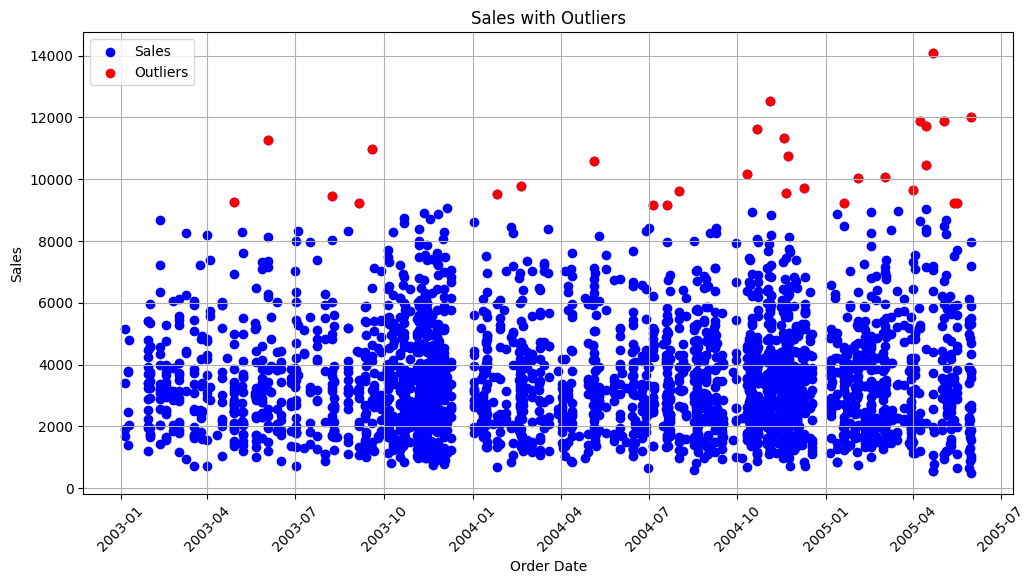

In [29]:
from scipy import stats

# Tính Z-score để phát hiện outliers
z_scores = stats.zscore(df['SALES'])
df_outliers = df[abs(z_scores) > 3]  # Chọn outliers có Z-score > 3

# Vẽ biểu đồ các outliers
plt.figure(figsize=(12,6))
plt.scatter(df['ORDERDATE'], df['SALES'], color='blue', label='Sales')
plt.scatter(df_outliers['ORDERDATE'], df_outliers['SALES'], color='red', label='Outliers')
plt.title('Sales with Outliers')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Đánh Giá Phát Hiện Outliers:
Mô tả:
Biểu đồ này hiển thị các điểm outliers (màu đỏ) trong dữ liệu doanh thu (màu xanh). Các outliers có thể là các đơn hàng có doanh thu rất cao hoặc thấp bất thường so với phần còn lại.

Đánh Giá:
Outliers (Màu Đỏ): Các điểm outliers có thể là các đơn hàng đặc biệt, có doanh thu cực kỳ cao hoặc thấp, có thể ảnh hưởng đến sự chính xác của các phân tích và dự báo.

Các yếu tố tác động: Việc phát hiện và xử lý các outliers giúp làm giảm sự ảnh hưởng của các điểm dữ liệu không điển hình, từ đó làm cho các mô hình dự báo trở nên chính xác hơn.

Kết luận:
Xử lý Outliers: Cần phải xem xét và xử lý các outliers này. Một số phương pháp có thể là loại bỏ hoặc thay thế chúng bằng giá trị trung bình hoặc trung vị để không làm sai lệch các phân tích sau này.



<ipython-input-30-11e770c3b6b1>:6: RuntimeWarning: invalid value encountered in greater
  df['SALES'] = df['SALES'].apply(lambda x: mean_sales if abs(stats.zscore([x])) > 3 else x)


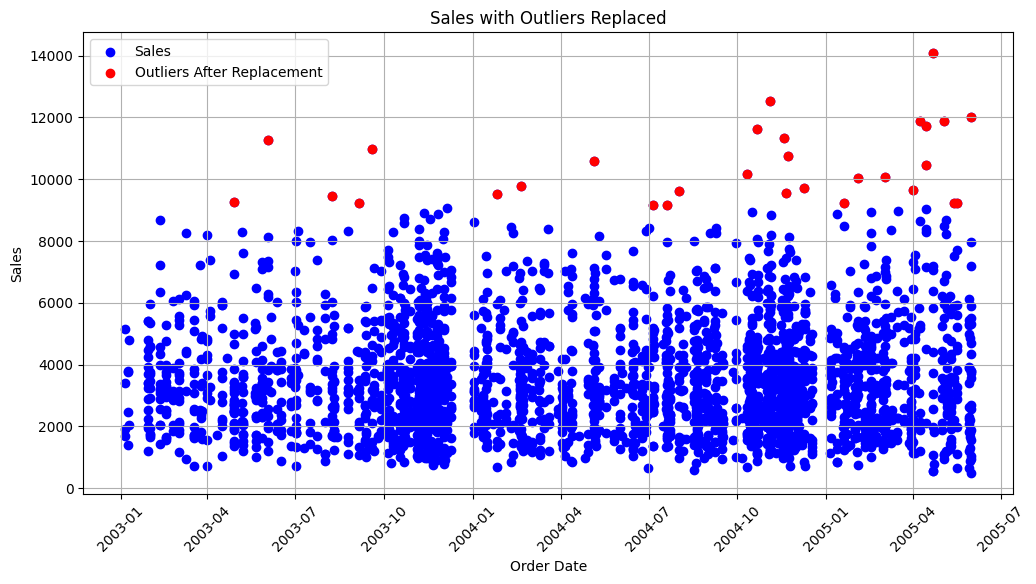

30

In [30]:
df['Z_Score'] = stats.zscore(df['SALES'])
df_outliers = df[abs(df['Z_Score']) > 3]

# Thay thế các outliers bằng giá trị trung bình
mean_sales = df['SALES'].mean()
df['SALES'] = df['SALES'].apply(lambda x: mean_sales if abs(stats.zscore([x])) > 3 else x)

# Kiểm tra lại các outliers
df['Z_Score'] = stats.zscore(df['SALES'])
df_outliers_after = df[abs(df['Z_Score']) > 3]

# Vẽ biểu đồ với các outliers đã được thay thế
plt.figure(figsize=(12,6))
plt.scatter(df['ORDERDATE'], df['SALES'], color='blue', label='Sales')
plt.scatter(df_outliers_after['ORDERDATE'], df_outliers_after['SALES'], color='red', label='Outliers After Replacement')
plt.title('Sales with Outliers Replaced')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Trả về số lượng outliers sau khi thay thế
len(df_outliers_after)


In [31]:
spark = SparkSession.builder.appName("SalesDataAnalysis").getOrCreate()
# Đọc dữ liệu từ file CSV vào Spark DataFrame
file_url = 'https://drive.google.com/uc?id=1sOkiSL5_lQcJFscw7EZhRbDU2zWtrmbt&export=download'
file_name = 'sales_data.csv'  # Choose a file name

# Download the file using wget
wget.download(file_url, file_name)
# Đọc tệp CSV, using encoding='latin-1'

df_spark = spark.read.csv(file_name, header=True, inferSchema=True)

# Hiển thị cấu trúc dữ liệu
df_spark.printSchema()

# Hiển thị vài dòng đầu tiên của dữ liệu
df_spark.show(5)


root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

In [32]:
from pyspark.ml.regression import LinearRegression


# Chọn các cột độc lập (features) và cột mục tiêu (label)
feature_columns = ['QUANTITYORDERED', 'PRICEEACH']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_spark = assembler.transform(df_spark)

# Chọn cột mục tiêu (label)
df_spark = df_spark.withColumnRenamed('SALES', 'label')

# Tạo mô hình Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='label')

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=1234)

# Huấn luyện mô hình
lr_model = lr.fit(train_data)

# Dự đoán trên tập kiểm tra
test_results = lr_model.evaluate(test_data)

# Hiển thị các kết quả
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")


Root Mean Squared Error (RMSE): 955.417289694199
R2: 0.7293704254083814


In [33]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

# Tạo mô hình Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='label')

# Tạo ParamGridBuilder để tạo các tham số cần thử nghiệm
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Sử dụng CrossValidator để thực hiện cross-validation
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Sử dụng 5 folds cross-validation

# Huấn luyện mô hình
cvModel = crossval.fit(train_data)

# Lấy mô hình tốt nhất sau khi tối ưu hóa hyperparameters
best_lr_model = cvModel.bestModel

# In ra các tham số của mô hình tốt nhất
print("Best regParam: ", best_lr_model._java_obj.getRegParam())
print("Best elasticNetParam: ", best_lr_model._java_obj.getElasticNetParam())


Best regParam:  0.1
Best elasticNetParam:  1.0


In [34]:
# Dự đoán trên tập kiểm tra
predictions = best_lr_model.transform(test_data)

# Khởi tạo RegressionEvaluator để tính toán RMSE và R2
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Tính RMSE và R2 cho mô hình tốt nhất
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# In kết quả đánh giá
print(f"RMSE for the best model: {rmse}")
print(f"R2 for the best model: {r2}")


RMSE for the best model: 955.4093413745135
R2 for the best model: 0.7293749282396591


In [35]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Tạo mô hình GBT
gbt = GBTRegressor(featuresCol='features', labelCol='label')

# Tạo ParamGridBuilder với ít tham số hơn
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .addGrid(gbt.maxBins, [16, 32]) \
    .build()

# Sử dụng CrossValidator với numFolds giảm xuống 3
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=3)  # Giảm số folds xuống 3

# Huấn luyện mô hình với cross-validation
cvModel_gbt = crossval_gbt.fit(train_data)

# Lấy mô hình tốt nhất
best_gbt_model = cvModel_gbt.bestModel

# In ra các tham số của mô hình tốt nhất
print("Best maxDepth: ", best_gbt_model._java_obj.getMaxDepth())
print("Best maxIter: ", best_gbt_model._java_obj.getMaxIter())
print("Best stepSize: ", best_gbt_model._java_obj.getStepSize())


Best maxDepth:  5
Best maxIter:  20
Best stepSize:  0.2


In [36]:
# Dự đoán trên tập kiểm tra
predictions_gbt = best_gbt_model.transform(test_data)

# Đánh giá mô hình với RMSE và R2
rmse_gbt = evaluator.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

# In kết quả đánh giá
print(f"RMSE for the tuned GBT model: {rmse_gbt}")
print(f"R2 for the tuned GBT model: {r2_gbt}")


RMSE for the tuned GBT model: 823.3781187199022
R2 for the tuned GBT model: 0.7990038654920972


In [37]:
rf = RandomForestRegressor(featuresCol='features', labelCol='label')
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid_rf,
                              evaluator=evaluator,
                              numFolds=5)
cvModel_rf = crossval_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
print("Best numTrees: ", best_rf_model.numTrees)
print("Best maxDepth: ", best_rf_model._java_obj.getMaxDepth())

predictions_rf = best_rf_model.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)
print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - R2: {r2_rf}")

# ----------------- ENSEMBLE: KẾT HỢP CÁC MÔ HÌNH (LR, GBT, RF) -----------------
# Thêm cột 'id' vào test_data để join dự đoán
test_data_with_id = test_data.withColumn("id", monotonically_increasing_id())

# Dự đoán từ các mô hình
predictions_lr = best_lr_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_lr"))
predictions_gbt = best_gbt_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_gbt"))
predictions_rf = best_rf_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_rf"))

# Ghép các dự đoán theo cột 'id'
ensemble_predictions = predictions_lr.join(predictions_gbt, on="id") \
                                       .join(predictions_rf, on="id")

# Tính trung bình dự đoán của 3 mô hình
ensemble_predictions = ensemble_predictions.withColumn(
    "ensemble_prediction",
    (col("pred_lr") + col("pred_gbt") + col("pred_rf")) / 3
)

# Join với nhãn thật để đánh giá
ensemble_with_label = ensemble_predictions.join(
    test_data_with_id.select("id", "label"), on="id"
)

ensemble_rmse = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="rmse") \
    .evaluate(ensemble_with_label)
ensemble_r2 = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="r2") \
    .evaluate(ensemble_with_label)

print(f"Ensemble Model (LR, GBT, RF) - RMSE: {ensemble_rmse}")
print(f"Ensemble Model (LR, GBT, RF) - R2: {ensemble_r2}")

Best numTrees:  RandomForestRegressor_4fe65c193ca1__numTrees
Best maxDepth:  10
Random Forest - RMSE: 865.7073449586318
Random Forest - R2: 0.7778065425369884
Ensemble Model (LR, GBT, RF) - RMSE: 824.469037731284
Ensemble Model (LR, GBT, RF) - R2: 0.7984709007254114


In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id, col, lit



# ----------------- MÔ HÌNH LINEAR REGRESSION -----------------
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
test_results = lr_model.evaluate(test_data)
print(f"Linear Regression - RMSE: {test_results.rootMeanSquaredError}")
print(f"Linear Regression - R2: {test_results.r2}")

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator,
                             numFolds=5)
cvModel_lr = crossval_lr.fit(train_data)
best_lr_model = cvModel_lr.bestModel
print("Best regParam: ", best_lr_model._java_obj.getRegParam())
print("Best elasticNetParam: ", best_lr_model._java_obj.getElasticNetParam())

predictions_lr = best_lr_model.transform(test_data)
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
rmse_lr = evaluator_rmse.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)
print(f"Linear Regression (tuned) - RMSE: {rmse_lr}")
print(f"Linear Regression (tuned) - R2: {r2_lr}")

# ----------------- MÔ HÌNH GBT -----------------
gbt = GBTRegressor(featuresCol='features', labelCol='label')
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .addGrid(gbt.maxBins, [16, 32]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=3)
cvModel_gbt = crossval_gbt.fit(train_data)
best_gbt_model = cvModel_gbt.bestModel
print("Best maxDepth: ", best_gbt_model._java_obj.getMaxDepth())
print("Best maxIter: ", best_gbt_model._java_obj.getMaxIter())
print("Best stepSize: ", best_gbt_model._java_obj.getStepSize())

predictions_gbt = best_gbt_model.transform(test_data)
rmse_gbt = evaluator.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)
print(f"GBT - RMSE: {rmse_gbt}")
print(f"GBT - R2: {r2_gbt}")

# ----------------- MÔ HÌNH RANDOM FOREST (RF) -----------------
rf = RandomForestRegressor(featuresCol='features', labelCol='label')
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid_rf,
                              evaluator=evaluator,
                              numFolds=5)
cvModel_rf = crossval_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
print("Best numTrees: ", best_rf_model.numTrees)
print("Best maxDepth: ", best_rf_model._java_obj.getMaxDepth())

predictions_rf = best_rf_model.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)
print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - R2: {r2_rf}")

# ----------------- ENSEMBLE: KẾT HỢP CÁC MÔ HÌNH (LR, GBT, RF) -----------------
# Thêm cột 'id' vào test_data để join dự đoán
test_data_with_id = test_data.withColumn("id", monotonically_increasing_id())

# Dự đoán từ các mô hình
predictions_lr = best_lr_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_lr"))
predictions_gbt = best_gbt_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_gbt"))
predictions_rf = best_rf_model.transform(test_data_with_id) \
    .select("id", col("prediction").alias("pred_rf"))

# Ghép các dự đoán theo cột 'id'
ensemble_predictions = predictions_lr.join(predictions_gbt, on="id") \
                                       .join(predictions_rf, on="id")

# --- Phương pháp 1: Simple Averaging ---
ensemble_predictions = ensemble_predictions.withColumn(
    "ensemble_prediction",
    (col("pred_lr") + col("pred_gbt") + col("pred_rf")) / 3
)

# --- Phương pháp 2: Weighted Averaging ---
# Tính trọng số dựa trên inverse RMSE (mô hình có RMSE thấp sẽ có trọng số cao hơn)
inv_lr = 1 / rmse_lr
inv_gbt = 1 / rmse_gbt
inv_rf = 1 / rmse_rf
total_inv = inv_lr + inv_gbt + inv_rf
weight_lr = inv_lr / total_inv
weight_gbt = inv_gbt / total_inv
weight_rf = inv_rf / total_inv

print("Weights -> LR:", weight_lr, "GBT:", weight_gbt, "RF:", weight_rf)

ensemble_predictions = ensemble_predictions.withColumn(
    "ensemble_prediction_weighted",
    col("pred_lr") * lit(weight_lr) + col("pred_gbt") * lit(weight_gbt) + col("pred_rf") * lit(weight_rf)
)

# Đánh giá ensemble (simple averaging)
ensemble_with_label = ensemble_predictions.join(
    test_data_with_id.select("id", "label"), on="id"
)

ensemble_rmse = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="rmse") \
    .evaluate(ensemble_with_label)
ensemble_r2 = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="r2") \
    .evaluate(ensemble_with_label)

print(f"Ensemble Model (Simple Averaging) - RMSE: {ensemble_rmse}")
print(f"Ensemble Model (Simple Averaging) - R2: {ensemble_r2}")

# Đánh giá ensemble (weighted averaging)
ensemble_rmse_weighted = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction_weighted", metricName="rmse") \
    .evaluate(ensemble_with_label)
ensemble_r2_weighted = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction_weighted", metricName="r2") \
    .evaluate(ensemble_with_label)

print(f"Ensemble Model (Weighted Averaging) - RMSE: {ensemble_rmse_weighted}")
print(f"Ensemble Model (Weighted Averaging) - R2: {ensemble_r2_weighted}")


Linear Regression - RMSE: 955.417289694199
Linear Regression - R2: 0.7293704254083814
Best regParam:  0.1
Best elasticNetParam:  1.0
Linear Regression (tuned) - RMSE: 955.4093413745135
Linear Regression (tuned) - R2: 0.7293749282396591
Best maxDepth:  5
Best maxIter:  20
Best stepSize:  0.2
GBT - RMSE: 823.3781187199022
GBT - R2: 0.7990038654920972
Best numTrees:  RandomForestRegressor_9c9bf65f147c__numTrees
Best maxDepth:  10
Random Forest - RMSE: 865.7073449586318
Random Forest - R2: 0.7778065425369884
Weights -> LR: 0.3063753570223704 GBT: 0.3555035911340511 RF: 0.3381210518435786
Ensemble Model (Simple Averaging) - RMSE: 824.469037731284
Ensemble Model (Simple Averaging) - R2: 0.7984709007254114
Ensemble Model (Weighted Averaging) - RMSE: 822.1882715288866
Ensemble Model (Weighted Averaging) - R2: 0.7995843567191478


In [39]:
# ----------------- STACKING ENSEMBLE -----------------
# Ghép các dự đoán từ LR, GBT, RF (đã có cột "id" trong test_data_with_id)
stack_df = predictions_lr.join(predictions_gbt, on="id") \
                         .join(predictions_rf, on="id") \
                         .join(test_data_with_id.select("id", "label"), on="id")

# Tạo vector features cho meta-model từ các dự đoán của các mô hình cơ sở
from pyspark.ml.feature import VectorAssembler
assembler_stack = VectorAssembler(inputCols=["pred_lr", "pred_gbt", "pred_rf"],
                                  outputCol="stack_features")
stack_df = assembler_stack.transform(stack_df)

# Huấn luyện meta-model (Linear Regression) dựa trên các đặc trưng là các dự đoán từ các mô hình cơ sở
meta_lr = LinearRegression(featuresCol="stack_features", labelCol="label")
meta_model = meta_lr.fit(stack_df)

# Dự đoán bằng meta-model để có dự đoán cuối cùng
stack_predictions = meta_model.transform(stack_df)

# Đổi tên cột dự đoán của meta-model để đánh giá
stack_predictions = stack_predictions.withColumnRenamed("prediction", "meta_prediction")

meta_rmse = RegressionEvaluator(labelCol="label", predictionCol="meta_prediction", metricName="rmse") \
    .evaluate(stack_predictions)
meta_r2 = RegressionEvaluator(labelCol="label", predictionCol="meta_prediction", metricName="r2") \
    .evaluate(stack_predictions)

print(f"Stacking Ensemble Model (Meta LR) - RMSE: {meta_rmse}")
print(f"Stacking Ensemble Model (Meta LR) - R2: {meta_r2}")


Stacking Ensemble Model (Meta LR) - RMSE: 809.843292618571
Stacking Ensemble Model (Meta LR) - R2: 0.805557569266216
